In [2]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score
import VaDE_autoencoder
from VaDE_autoencoder import SimpleAutoencoder, VaDE, ClusteringEvaluationCallback

pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

find landmark files

In [4]:
# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

# Training the autoencoder

create and train autoencoder model

In [4]:
!nvidia-smi

Wed Dec  2 13:12:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0  On |                  N/A |
| 26%   40C    P8    17W / 250W |    683MiB / 12194MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import VaDE_autoencoder
from VaDE_autoencoder import SimpleAutoencoder, VaDE
%pdb on
seqlen = 30
model = VaDE(landmark_files, n_neurons=[2*12*seqlen, 512, 512, 30], lr=2e-3, seqlen=seqlen, k=30, batch_norm=True)

logger = pl.loggers.WandbLogger("landmarks VaDE")
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, callbacks=[ClusteringEvaluationCallback()],
                     log_every_n_steps=10, max_epochs=50, logger=logger)
trainer.fit(model)

Automatic pdb calling has been turned ON


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 649 K 
1 | decoder | Sequential | 649 K 


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


global_step,67109
loss,0.02692
regularization,81.3998
epoch,14
_step,1356
_runtime,495
_timestamp,1606987166


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▂▂▂▂▂▂▁▂▂▂▂▂▁▂▆▂▁▂▂▂▂▂▂▂▂▂▁▅█▂▁▁▂▁▁▂▂▂▁▁
regularization,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▆▆▇▇▇▇█▇███
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name        | Type               | Params
---------------------------------------------------
0 | encoder     | Sequential         | 633 K 
1 | latent_dist | LatentDistribution | 30 K  
2 | decoder     | Sequential         | 280 K 
3 | out_dist    | LatentDistribution | 369 K 


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [7]:
model.cuda()
all_dl = data.DataLoader(model.all_ds, batch_size=1024, shuffle=False, num_workers=8)
labels, encs = model.cluster_data(dl=all_dl)
VaDE_autoencoder.entropy(labels)

3.001650189220435

In [86]:
from torch import distributions as D
def cluster_data(model, dl=None):
    if not dl:
        dl = model.val_dataloader()
    model.eval()
    sigma_c = torch.exp(model.logvar_c / 2)
    vade_gmm = D.MixtureSameFamily(D.Categorical(logits=model.mixture_logits), D.Normal(model.mu_c, sigma_c))
    labels = []
    X_encoded = []
    with torch.no_grad():
        for bx in dl:
            x_encoded = model.latent_dist(model.encoder(bx.cuda())).loc
            X_encoded.append(x_encoded)
            log_p_z_given_c = vade_gmm.component_distribution.log_prob(x_encoded.unsqueeze(2)).sum(dim=1)
            labels.append((log_p_z_given_c + vade_gmm.mixture_distribution.logits).softmax(dim=-1).argmax(dim=-1))

    labels = torch.cat(labels).cpu().numpy()
    X_encoded = torch.cat(X_encoded).cpu().numpy()
    return labels, X_encoded

dl1 = data.DataLoader(model.all_ds, batch_size=8, shuffle=False, num_workers=8)
dl2 = data.DataLoader(model.all_ds, batch_size=1024, shuffle=False, num_workers=8)


l1, encs1 = cluster_data(model, dl1)
l2, encs2 = cluster_data(model, dl2)

In [12]:
from collections import Counter
Counter(labels).most_common()

[(28, 201675),
 (23, 138055),
 (22, 114921),
 (16, 99346),
 (26, 83834),
 (9, 81761),
 (15, 71443),
 (11, 65470),
 (5, 56949),
 (24, 48802),
 (20, 48519),
 (25, 47200),
 (6, 46181),
 (0, 43284),
 (27, 42444),
 (14, 37174),
 (1, 36703),
 (17, 28651),
 (2, 24205),
 (21, 21651),
 (18, 18941),
 (10, 17689),
 (12, 15714),
 (19, 14297),
 (3, 13432),
 (7, 8572),
 (29, 4128),
 (4, 473)]

In [24]:
model_dir = Path('models/vade_03_12')
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_dir / 'model.pt')

In [19]:
from collections import Counter
Counter(labels).most_common()

[(17, 172525),
 (27, 149701),
 (5, 100731),
 (15, 99762),
 (25, 91147),
 (28, 72874),
 (14, 68291),
 (4, 61643),
 (2, 61233),
 (0, 58979),
 (8, 44563),
 (22, 43861),
 (9, 42741),
 (3, 41618),
 (24, 35255),
 (13, 33500),
 (18, 32328),
 (19, 26189),
 (7, 25958),
 (23, 25856),
 (6, 22257),
 (11, 21544),
 (12, 18760),
 (26, 15628),
 (21, 15065),
 (20, 15001),
 (10, 14604),
 (1, 10377),
 (16, 4993),
 (29, 4530)]

In [11]:
seqlen = 30

model = VaDE(landmark_files, n_neurons=[2*12*seqlen, 512, 512, 30], lr=2e-3, seqlen=seqlen, k=30, batch_norm=True, pretrain=False)
model.prepare_data()
model.load_state_dict(torch.load('models/vade_11_24/model.pt'))

<All keys matched successfully>

In [10]:
model.mixture_logits.softmax(0)

tensor([0.0419, 0.0214, 0.0452, 0.0332, 0.0450, 0.0774, 0.0174, 0.0175, 0.0306,
        0.0319, 0.0126, 0.0162, 0.0162, 0.0291, 0.0481, 0.0529, 0.0044, 0.0779,
        0.0277, 0.0227, 0.0132, 0.0126, 0.0296, 0.0190, 0.0268, 0.0674, 0.0191,
        0.0776, 0.0505, 0.0147], device='cuda:0', grad_fn=<SoftmaxBackward>)

compare the original and reconstructed data, each plot for a different feature / coordinate

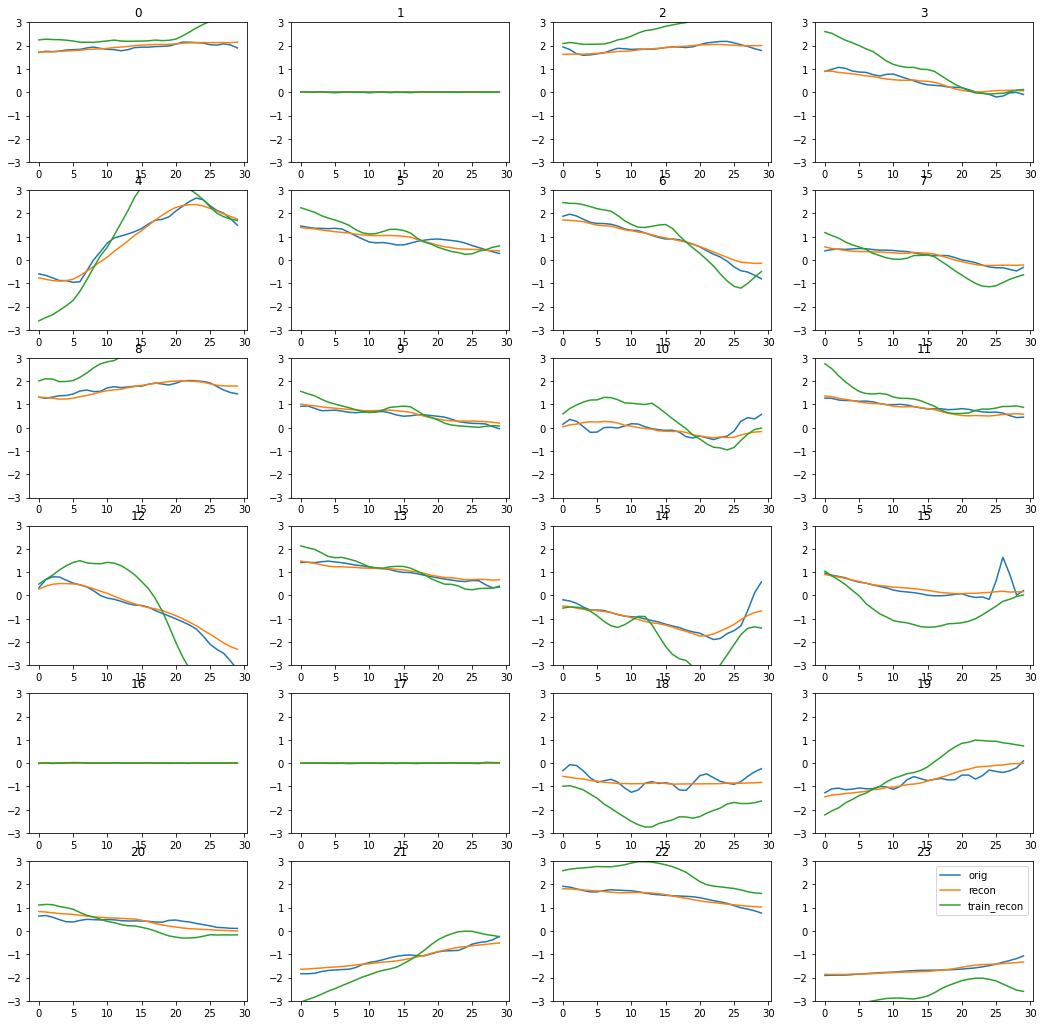

In [13]:

def compare_plot(x, y, z=None):
    x = x.reshape(seqlen, 24)
    y = y.reshape(seqlen, 24)
    if z is not None:
        z = z.reshape(seqlen, 24)
    fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(18, 18))
    for i in range(6):
        for j in range(4):
            idx = 4*i + j
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            if z is not None:
                axes[i][j].plot(z[:,idx], label='train_recon')
            axes[i][j].set_title(f"{idx}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()
 

model.eval()
with torch.no_grad():
    bx = next(iter(model.train_dataloader()))
    out = model(bx.cuda()).loc
    model.train()
    out_train = model(bx.cuda()).loc
_idx = 31
compare_plot(bx[_idx].cpu().numpy(), out[_idx].cpu().numpy(), out_train[_idx].cpu().numpy())

# Clustering the data

loading the landmark coordinates from all videos

In [22]:
# landmark_ds = LandmarkDataset(landmark_files[0])
coords = model.coords


creating the dataset from all the coordinates

In [14]:
N, n_coords, _ = model.coords[0].shape
all_data = [crds.reshape(-1, n_coords*2) for crds in model.coords]
data_lengths = [d.shape[0] - model.seqlen for d in all_data]
video_change_idxs = np.cumsum(data_lengths)[:-1]
# all_data = [SequenceDataset(d, seqlen=model.seqlen, diff=False, step=1) for d in all_data]
# all_data = ConcatDataset(all_data)

In [29]:
new_labels, new_X_encoded = model.cluster_data(DataLoader(all_data, batch_size=1024, num_workers=8, ))

clustering the data and splitting into segments

In [20]:
K = 30
model.cuda()
labels, X_encoded = model.cluster_data(DataLoader(model.all_ds, batch_size=1024, num_workers=8))
'''
split the sequence of labels and returns the sequence of segments of the form:
      [(label0, segment_start0, segment_length0), ...]
for example:
44422222227777  ->  [(4, 0, 3), (2, 7), (7, 4)]
'''
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4 + model.seqlen*2, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen*2
    return sequence

labels_dict = dict(zip(landmark_files, 
                        np.split(labels, indices_or_sections=video_change_idxs)))

data_dict = dict(zip(landmark_files,
                    np.split(all_data, indices_or_sections=video_change_idxs)))

segment_dict = dict(zip(landmark_files, 
                        map(split_labels, np.split(labels, indices_or_sections=video_change_idxs))))

X_encoded_dict = dict(zip(landmark_files,
                         np.split(X_encoded, indices_or_sections=video_change_idxs)))


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [25]:
VaDE_autoencoder.entropy(labels)

2.174963673263396

In [25]:
import pickle
from pathlib import Path
# model_dir = Path('models/vade_11_24/')

np.save(model_dir / 'labels', labels)

with open(model_dir / 'labels_dict.pkl', 'wb') as file:
    pickle.dump(labels_dict, file)
    
with open(model_dir / 'data_dict.pkl', 'wb') as file:
    pickle.dump(data_dict, file)
    
with open(model_dir / 'segments_dict.pkl', 'wb') as file:
    pickle.dump(segment_dict, file)
    
with open(model_dir / 'x_encoded_dict.pkl', 'wb') as file:
    pickle.dump(X_encoded_dict, file)

TSNE plot of clusters

In [26]:
sample_idxs = np.random.choice(X_encoded.shape[0], size=10000, replace=False)
X_sample = X_encoded[sample_idxs]
sample_labels = labels[sample_idxs]

In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X_2d = tsne.fit_transform(X_sample)

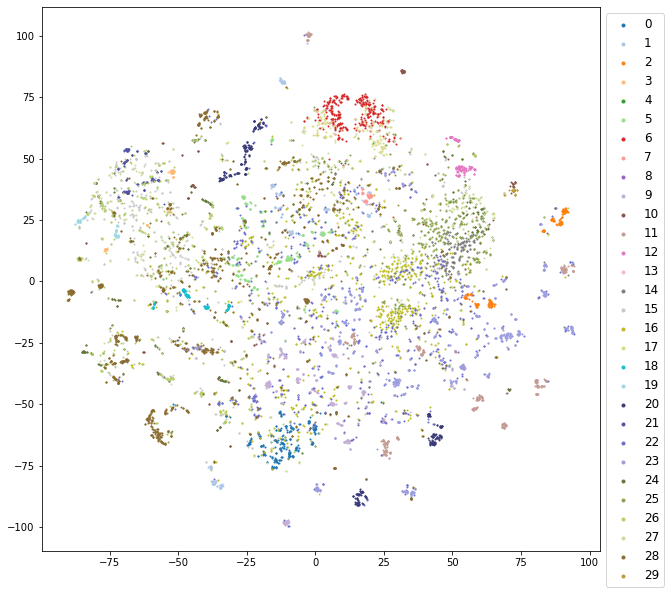

In [31]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=3)
    plt.savefig('plots/tsne.png')

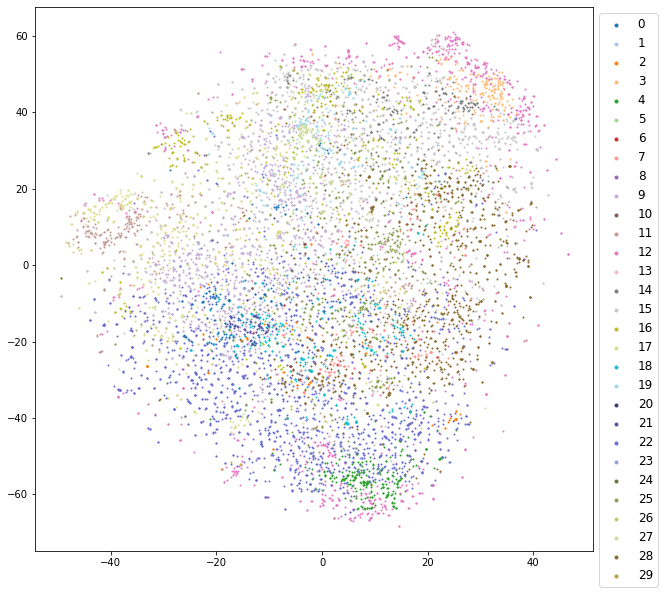

In [29]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=3)
    plt.savefig('plots/tsne.png')

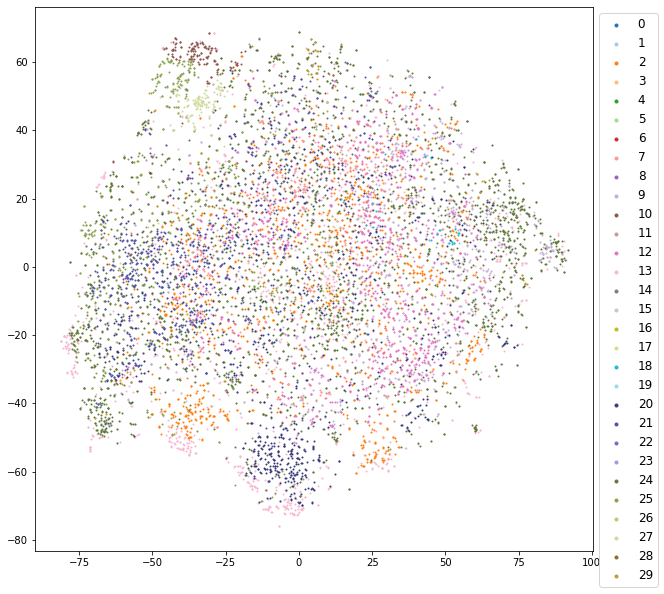

In [30]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=3)
    plt.savefig('plots/tsne.png')

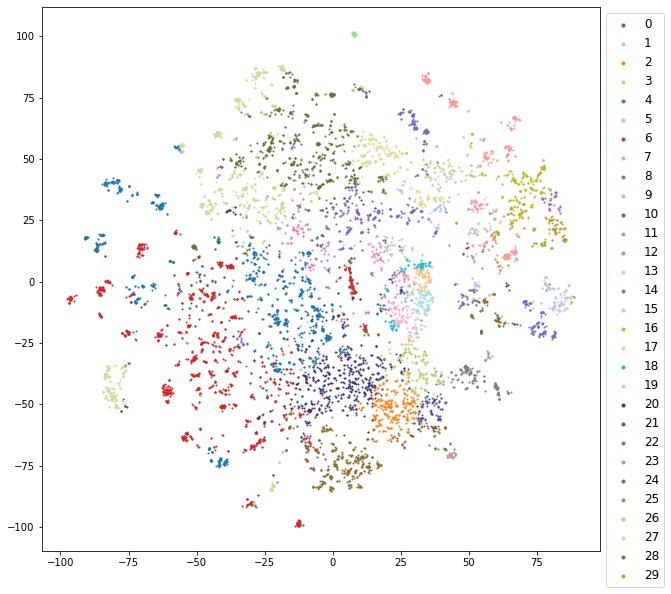

In [19]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=3)
    plt.savefig('plots/tsne.png')

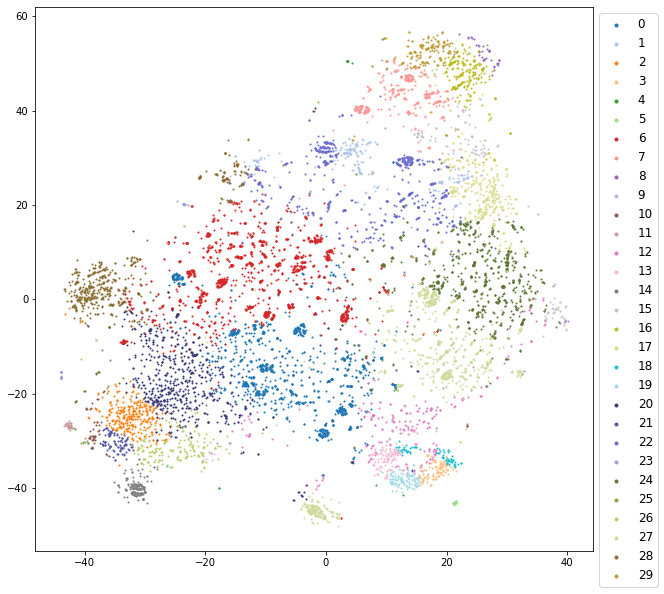

In [12]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=3)
    plt.savefig('plots/tsne.png')

In [21]:
body_parts = model.landmark_datasets[0].body_parts
bodyparts_dict = dict(zip(body_parts, range(len(body_parts))))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
coords = model.coords
def plot_segments(axis, vid_file_idx, start_idx, end_idx, bparts):
    bparts_idxs = [bodyparts_dict[bp] for bp in bparts]
    plot_coords = coords[vid_file_idx][start_idx + model.seqlen//2: end_idx + model.seqlen//2, bparts_idxs]
    duration = (end_idx - start_idx) * (1000 / 60)
    for i, body_part in enumerate(bparts):
        axis.plot(plot_coords[:,i,0], label=f"{body_part}_x")
        axis.plot(plot_coords[:,i,1], label=f"{body_part}_y")
    ymin, ymax = axis.get_ybound()
    lbls = labels_dict[landmark_files[vid_file_idx]][start_idx: end_idx]
#     label_dict = dict(zip(sorted(list(set(lbls))), range(len(set(lbls)))))
    segment_edges = np.where(np.diff(lbls) != 0)[0]
    segment_edges = np.append(0, segment_edges)
    segment_edges = np.append(segment_edges, end_idx - start_idx - 1)
    segment_labels = lbls[segment_edges]
    axis.margins(0, 0)
    axis.vlines(segment_edges, ymin=ymin, ymax=ymax, color='black', linestyle='dashed')
    for i in range(1, len(segment_edges)):
        cluster_color = cluster_colors[lbls[segment_edges[i]]]
        axis.fill_betweenx([ymin, ymax], segment_edges[i-1], segment_edges[i], color=cluster_color, alpha=0.5)
    color_patches = [mpatches.Patch(color=cluster_colors[i], label=f'cluster {i}', alpha=0.5) for i in set(lbls)]
    cluster_color_legend = axis.legend(handles=color_patches, bbox_to_anchor=(1.0, 0.0), loc='lower left', title='clusters')
    ax = plt.gca().add_artist(cluster_color_legend)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, bbox_to_anchor=(1.0, 1), title="body parts")
    axis.set_title("landmark coordinates timeseries")
    axis.set_xticks(np.arange(0, end_idx - start_idx, step=30))
    axis.set_xticklabels(np.arange(0, duration/1000, step=0.5))
    axis.set_xlabel("time [seconds]")

Automatic pdb calling has been turned ON


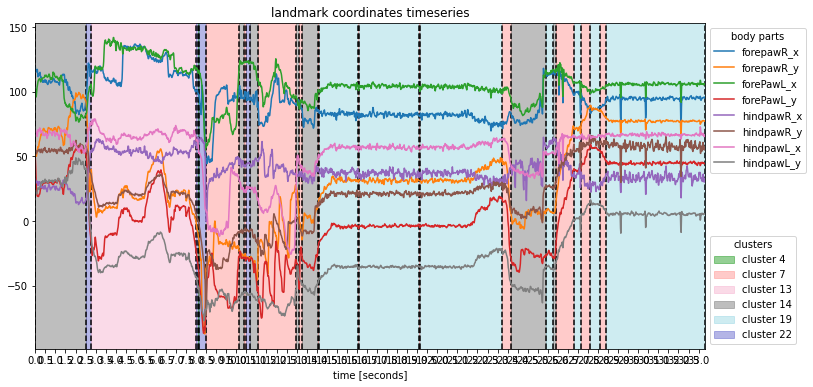

In [115]:
# plt.figure(figsize=(12, 6))
# ax = plt.subplot().axes
# %pdb on
# plot_segments(ax, 6, 8000, 10000, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])


Automatic pdb calling has been turned ON


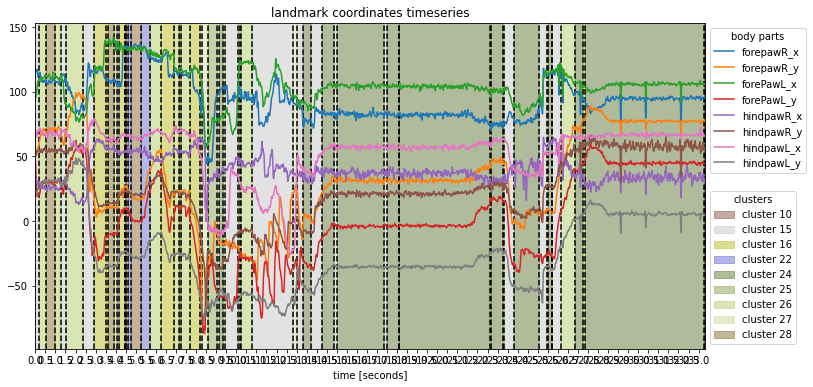

In [23]:
plt.figure(figsize=(12, 6))
ax = plt.subplot().axes
%pdb on
plot_segments(ax, 6, 8000, 10000, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords1.svg")

Automatic pdb calling has been turned ON


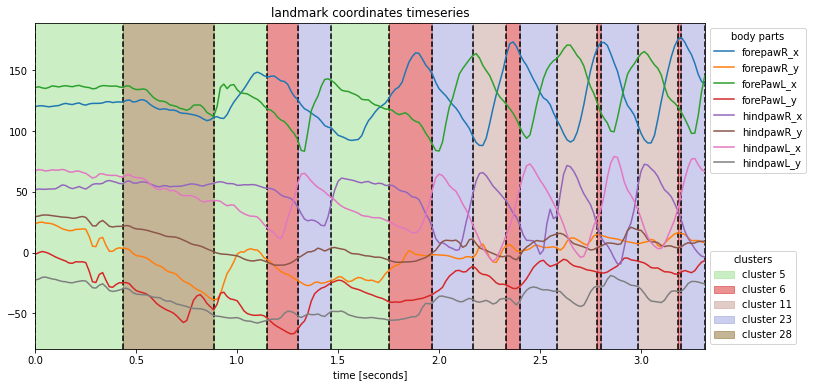

In [20]:

bodyparts_dict = dict(zip(landmark_ds.body_parts, range(len(landmark_ds.body_parts))))

def plot_segments(axis, vid_file_idx, start_idx, end_idx, bparts):
    bparts_idxs = [bodyparts_dict[bp] for bp in bparts]
    plot_coords = coords[vid_file_idx][start_idx + model.seqlen//2: end_idx + model.seqlen//2, bparts_idxs]
    duration = (end_idx - start_idx) * (1000 / 60)
    for i, body_part in enumerate(bparts):
        axis.plot(plot_coords[:,i,0], label=f"{body_part}_x")
        axis.plot(plot_coords[:,i,1], label=f"{body_part}_y")
    ymin, ymax = axis.get_ybound()
    lbls = labels_dict[landmark_files[vid_file_idx]][start_idx: end_idx]
#     label_dict = dict(zip(sorted(list(set(lbls))), range(len(set(lbls)))))
    segment_edges = np.where(np.diff(lbls) != 0)[0]
    segment_edges = np.append(0, segment_edges)
    segment_edges = np.append(segment_edges, end_idx - start_idx - 1)
    segment_labels = lbls[segment_edges]
    axis.margins(0, 0)
    axis.vlines(segment_edges, ymin=ymin, ymax=ymax, color='black', linestyle='dashed')
    for i in range(1, len(segment_edges)):
        cluster_color = cluster_colors[lbls[segment_edges[i]]]
        axis.fill_betweenx([ymin, ymax], segment_edges[i-1], segment_edges[i], color=cluster_color, alpha=0.5)
    color_patches = [mpatches.Patch(color=cluster_colors[i], label=f'cluster {i}', alpha=0.5) for i in set(lbls)]
    cluster_color_legend = axis.legend(handles=color_patches, bbox_to_anchor=(1.0, 0.0), loc='lower left', title='clusters')
    ax = plt.gca().add_artist(cluster_color_legend)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, bbox_to_anchor=(1.0, 1), title="body parts")
    axis.set_title("landmark coordinates timeseries")
    axis.set_xticks(np.arange(0, end_idx - start_idx, step=30))
    axis.set_xticklabels(np.arange(0, duration/1000, step=0.5))
    axis.set_xlabel("time [seconds]")

    
plt.figure(figsize=(12, 6))
ax = plt.subplot().axes
%pdb on
plot_segments(ax, 6, 800, 1000, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords1.svg")

some plots to show the cluster at each timestep

Automatic pdb calling has been turned ON


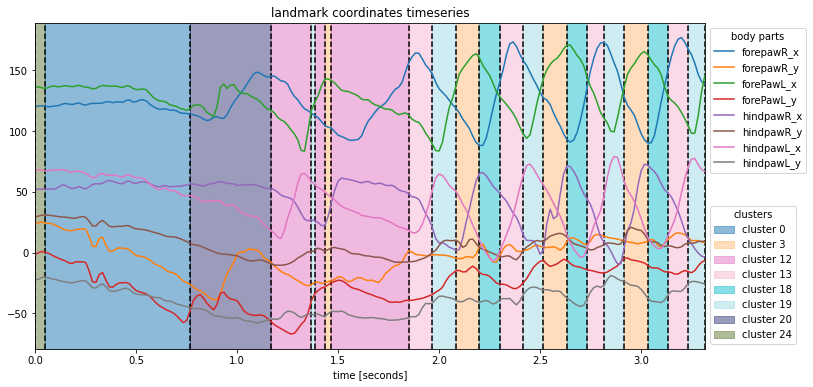

In [23]:

bodyparts_dict = dict(zip(landmark_datasets[0].body_parts, range(len(landmark_datasets[0]))))

def plot_segments(axis, vid_file_idx, start_idx, end_idx, bparts):
    bparts_idxs = [bodyparts_dict[bp] for bp in bparts]
    plot_coords = coords[vid_file_idx][start_idx + model.seqlen//2: end_idx + model.seqlen//2, bparts_idxs]
    duration = (end_idx - start_idx) * (1000 / 60)
    for i, body_part in enumerate(bparts):
        axis.plot(plot_coords[:,i,0], label=f"{body_part}_x")
        axis.plot(plot_coords[:,i,1], label=f"{body_part}_y")
    ymin, ymax = axis.get_ybound()
    lbls = labels_dict[landmark_files[vid_file_idx]][start_idx: end_idx]
#     label_dict = dict(zip(sorted(list(set(lbls))), range(len(set(lbls)))))
    segment_edges = np.where(np.diff(lbls) != 0)[0]
    segment_edges = np.append(0, segment_edges)
    segment_edges = np.append(segment_edges, end_idx - start_idx - 1)
    segment_labels = lbls[segment_edges]
    axis.margins(0, 0)
    axis.vlines(segment_edges, ymin=ymin, ymax=ymax, color='black', linestyle='dashed')
    for i in range(1, len(segment_edges)):
        cluster_color = cluster_colors[lbls[segment_edges[i]]]
        axis.fill_betweenx([ymin, ymax], segment_edges[i-1], segment_edges[i], color=cluster_color, alpha=0.5)
    color_patches = [mpatches.Patch(color=cluster_colors[i], label=f'cluster {i}', alpha=0.5) for i in set(lbls)]
    cluster_color_legend = axis.legend(handles=color_patches, bbox_to_anchor=(1.0, 0.0), loc='lower left', title='clusters')
    ax = plt.gca().add_artist(cluster_color_legend)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, bbox_to_anchor=(1.0, 1), title="body parts")
    axis.set_title("landmark coordinates timeseries")
    axis.set_xticks(np.arange(0, end_idx - start_idx, step=30))
    axis.set_xticklabels(np.arange(0, duration/1000, step=0.5))
    axis.set_xlabel("time [seconds]")

    
plt.figure(figsize=(12, 6))
ax = plt.subplot().axes
%pdb on
plot_segments(ax, 6, 800, 1000, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords1.svg")

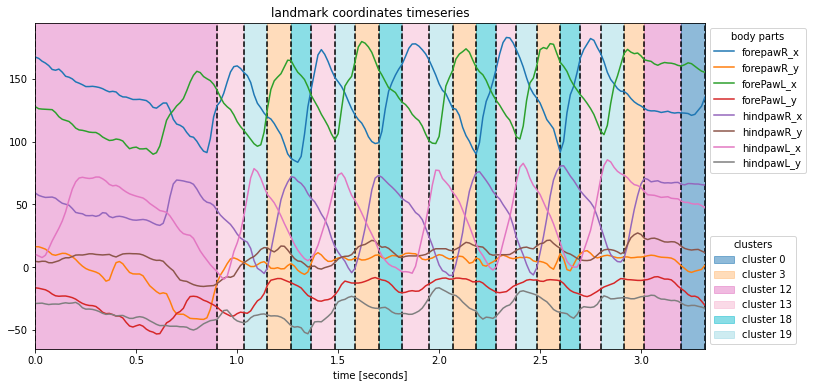

In [24]:
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plot_segments(ax, 6, 0, 200, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords2.svg")

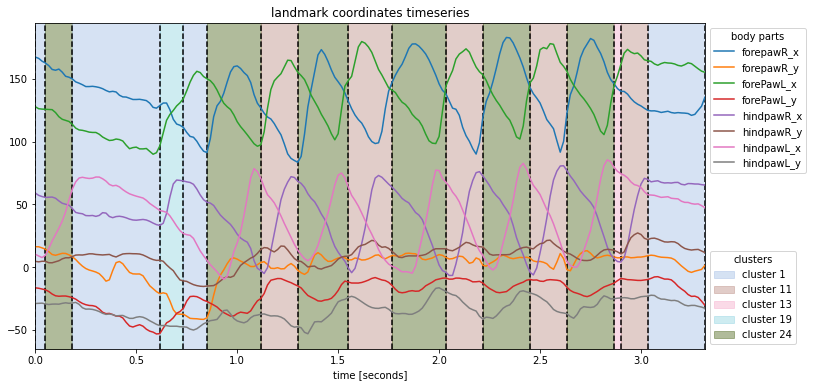

In [143]:
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plot_segments(ax, 6, 0, 200, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords2")

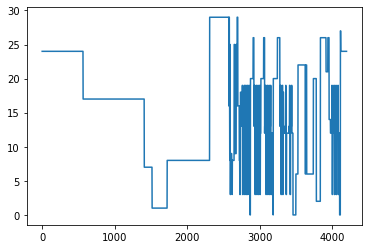

In [15]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[11800:16000])

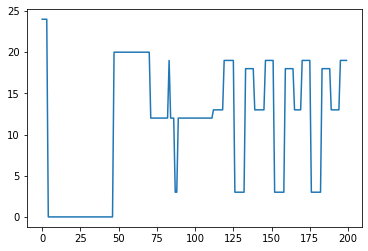

In [16]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[800:1000])

some histogram plots of lengths of some of the clusters

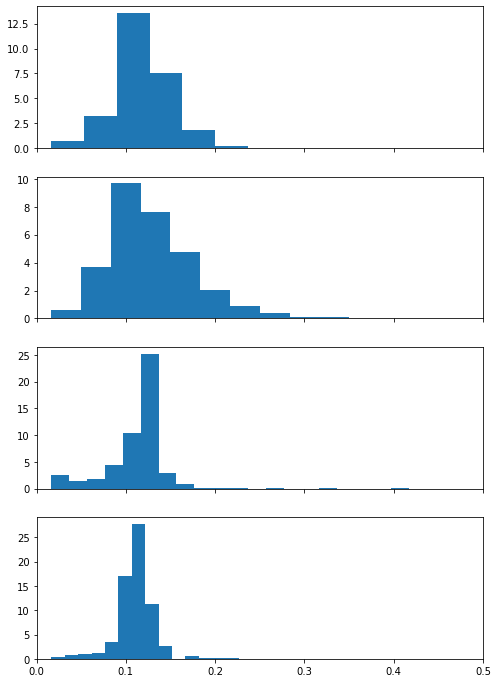

In [17]:
from collections import defaultdict
segments = split_labels(labels)
segment_lengths = defaultdict(list)
for seg in segments:
    if seg[2] < 200:
        segment_lengths[seg[0]].append(seg[2]/(4*60))
    
clusters_to_plot = [3, 13, 18, 19]
fig, axes = plt.subplots(ncols=1, nrows=len(clusters_to_plot), figsize=(8, 12), sharex=True)
for i, cl in enumerate(clusters_to_plot):
    axes[i].hist(segment_lengths[cl], bins=20, density=True)
    axes[i].set_xlim(0, 0.5)

Save examples from cluster as frames

In [146]:
import cv2 as cv
from PIL import Image
import importlib
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

def read_clip_as_frames(cap: cv.VideoCapture, start_idx, end_idx, df, fps=10):
    frame_gen = clip_videos.extract_labeled_cut_frames(cap, start_idx, end_idx, df)
    write_every = int(cap.get(cv.CAP_PROP_FPS) / fps)
    frames = []
    for i, frame in enumerate(frame_gen):
        if i % write_every == 0:
            frames.append(frame)
    return frames

# landmarks_file = landmark_files[6]
# df = landmark_datasets[6].df
# video_file = str(landmarks_file.parent / re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name))
# vid_cap = cv.VideoCapture(video_file)
# vid_cap.open(video_file)
# frames = read_clip_as_frames(vid_cap, 0, 200, df)
# frames = read_clip_as_frames(vid_cap, 1000, 1200, df)
# frames = read_clip_as_frames(vid_cap, 300, 500, df)
# vid_cap.release()
# ret

In [92]:
img = Image.fromarray(np.concatenate(frames, axis=1))
img.save('img.jpg')

In [147]:
def save_clips_as_frames(landmarks_file, cluster_segments, save_dir, min_seg_len=10, fps=20, n_samples=15):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = str(landmarks_file.parent / video_file)
    assert os.path.exists(video_file)
    vid_cap = cv.VideoCapture(video_file)
    vid_cap.open(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1], seg[2]))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=n_samples) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        print(cl_id)
        if not os.path.exists(save_dir / f'{cl_id}'):
            os.makedirs(save_dir / f'{cl_id}', exist_ok=True)
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        for i, mid_frame in enumerate(mid_frames):
            start_idx, end_idx = mid_frame - n_frames//2, mid_frame + n_frames//2
            frames = read_clip_as_frames(vid_cap, start_idx, end_idx, df=df, fps=fps)
            img = Image.fromarray(np.concatenate(frames, axis=1))
            img.save(save_dir / f'{cl_id}' / f"{i}.jpg")
    vid_cap.release()

In [58]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
landmarks_file = landmark_files[6]
df = landmark_datasets[6].df
cluster_subset = [6, 15, 22, 7, 2, 12, 25]
segments = [seg for seg in segment_dict[landmarks_file] if seg[0] in cluster_subset]
save_dir = Path("clusters/frames/oct28_2/")
save_clips_as_frames(landmarks_file, segment_dict[landmarks_file], save_dir, n_samples=12)

1
24
19
11
14
29
5
17
6
26
9
13
7
22
20
8
0
21
15
18


# Saving clips of clusters from the videos

In [ ]:
import cv2 as cv
import importlib
import random
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

# save clips for each cluster from a single video
def save_clips(landmarks_file, cluster_segments, save_dir, min_seg_len=10):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = landmarks_file.parent / video_file
    assert os.path.exists(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1] + seg[2]//2, seg[2]//2))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                             save_file=f'{save_dir}/cluster_{cl_id}.mp4')

save clips from all videos, from each video in a seoperate directory.

In [ ]:
for lfile, segments in segment_dict.items():
    save_dir = f'clusters/sept15/{lfile.name[:4]}'
    if not os.path.exists(save_dir):
        save_clips(lfile, segments, save_dir)

## Not really important

In [ ]:
from collections import defaultdict
import random
split_at = np.where(np.diff(labels) != 0)[0] + 1
sequence = [[s[0], split_at[i-1], len(s)] for i, s in enumerate(np.split(labels, indices_or_sections=split_at))]
sequence[0][1] = 0
seg_lengths = defaultdict(list)
for seg in sequence:
    seg_lengths[seg[0]].append(seg[2])

sequence = [seq for seq in sequence if seq[2] > 5]

cluster_frames = defaultdict(list)
for seq in sequence:
    cluster_frames[seq[0]].append((seq[1]*4 + seq[2]*2, seq[2]*2))

cluster_frames = {c:cl for c, cl in cluster_frames.items() if len(cl)>25}
# len(cluster_frames)
cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}

In [ ]:
import cv2 as cv
import importlib
import clip_videos
importlib.reload(clip_videos)

video_file = data_root/'2020-03-23'/'Down'/'0008DeepCut_resnet50_Down2May25shuffle1_1030000_labeled.mp4'

In [ ]:
for cl_id,  cluster in cluster_samples.items():
    n_frames = [c[1] for c in cluster]
    print(cl_id, np.mean(n_frames), np.std(n_frames))

In [ ]:
df = LandmarkDataset(landmarks_file).df
for cl_id,  cluster in cluster_samples.items():
    mid_frames = [c[0] for c in cluster]
    n_frames = [c[1] for c in cluster]
    n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
    print(mid_frames)
    clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                         save_file=f'clusters/example_1/cluster_{cl_id}.mp4')

In [ ]:
!ls clusters/example_1

In [ ]:
# sequence = [seq[0] for seq in sequence]
from collections import defaultdict, Counter

def count_ngrams(sequence, max_n=10):
    N = len(sequence)
    counter = defaultdict(int)
    for k in range(1, max_n):
        for i in range(N-k):
            counter[tuple(sequence[i:i+k])] += 1
    return counter

def segment_sequence(sequence, max_n=5):
    N = len(sequence)
    sequence = tuple(sequence)
    ngram_count = count_ngrams(sequence, max_n=max_n)
    u_arr = np.zeros(N - 1)
    for k in range(0, N - 1):
        u_k = 0
        for n in range(2, min(max_n, k, N-k)):
            s_1, s_2 = ngram_count[sequence[k-n+1:k+1]], ngram_count[sequence[k+1:k+n+1]]
            u_k += np.mean([1 if s_1 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
            u_k += np.mean([1 if s_2 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
        u_arr[k] = u_k / max_n / 2
    
    sequence = list(sequence)
    segments = []
    prev_idx = 0
    for idx in range(1, N-1):
        if u_arr[idx-1] < u_arr[idx] and u_arr[idx+1] < u_arr[idx]:
            segments.append(sequence[prev_idx:idx+1])
            prev_idx = idx+1

    segments.append(sequence[prev_idx:])
    return segments

segments = segment_sequence(sequence, max_n=10)

In [ ]:
Counter(map(tuple, segments)).most_common(30)

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:2000])

In [ ]:
labels[:100]
27, 8, 26, 4, 10, 27, 8, 26, 4, 10, 27, 8, 26

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[3*10**4+1500:3*10**4+3000])

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[10**5+1500:10**5+3000])
# plt.plot(labels[250:400])

In [ ]:
re.search(r"(a+b+c+)+", "daaabbbccabc")

In [ ]:
chars = [chr(i) for i in range(ord('A'), ord('Z'))] + [chr(i) for i in range(ord('a'), ord('z'))]
labels_string = ''.join([chars[l] for l in labels])
labels_string[280:400]

In [ ]:
pat = re.compile(r"(K+Q+M+d+b+)+")
spans = [match.span() for match in re.finditer(pat, labels_string)]
span_lengths = [span[1] - span[0] for span in spans]
spans[3] 

In [ ]:
pat = re.compile(r"K+(?!Q*K+)")
fspans = [match.span() for match in re.finditer(pat, labels_string)]
fspans = [(max(0, s[0]-30), s[1]+30) for s in fspans]
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(18, 20))
for i in range(10):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*fspans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
print(len(re.findall(r"K+(?!K*Q+)", labels_string)))
print(len(re.findall(r"K+Q+(?!Q*M+)", labels_string)))
print(len(re.findall(r"K+Q+M+(?!M*d+)", labels_string)))
print(len(re.findall(r"K+Q+M+d+(?!d*b+)", labels_string)))


In [ ]:
fig, axes = plt.subplots(nrows=50, ncols=2, figsize=(18, 200))
for i in range(50):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*spans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:1000])

In [ ]:
n_clusters = len(set(labels))
transition_matrix = np.zeros((n_clusters, n_clusters))
for i in range(len(labels) - 1):
    transition_matrix[labels[i], labels[i+1]] += 1.

np.fill_diagonal(transition_matrix, val=0)

transition_matrix /= transition_matrix.sum(axis=0, keepdims=True)
plt.imshow(transition_matrix)

In [ ]:
def split(idx_arr):
    to_split = np.where(np.abs(np.diff(idx_arr)) > 1)[0] + 1
    return np.split(idx_arr, indices_or_sections=to_split)
behaviors = [split(np.where(y_gold==lbl)[0]) for lbl in set(y_gold)]
sections = [np.stack([np.mean(X_encoded[sec], axis=0) for sec in beh]) for beh in behaviors]
sections[1].shape